In [87]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import PIL.Image as Image

In [88]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

In [89]:
class Generator(nn.Module):
    def __init__(self, latents):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latents,256,4,2,1,bias=False), # 256 * 2 * 2
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256,128,3,1,1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128,256,4,1,1,bias=False), # 256 * 3 * 3
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256,256,4,2,1,bias=False), # 256 * 6 * 6
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256,128,4,1,1,bias=False), 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128,128,4,2,1,bias=False), 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128,128,3,1,1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128,64,4,2,1,bias=False), # 64 * 28 * 28
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64,64,3,1,1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64,64,3,1,2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 3, 3, 1, 2), # state size. 3 * 32 * 32
            nn.Tanh()
        )
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(10, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # state size. (64*8) x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # state size. (64*4) x 8 x 8
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # state size. (64*2) x 16 x 16
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. (64) x 32 x 32
            nn.ConvTranspose2d(64, 3, 3, 1, 1, bias=False),
            nn.Tanh()
            # state size. (3) x 64 x 64
        )
     
        
    def forward(self, x):
        
        # x = self.generator(x)
        x = self.main(x)
        # print(x.shape)
        return x
    

class Discriminator(nn.Module):
    def __init__(self,):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 3, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # nn.Conv2d(128, 128, 3, 2, 1, bias=False),
            # nn.BatchNorm2d(128),
            # nn.ReLU(inplace=True),

            nn.Conv2d(128, 64, 3, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

        )
          
        self.fc = nn.Sequential(
            nn.Linear(1024,2)
            # nn.Linear(256,1024),
            # nn.Linear(1024,256),
            # nn.Linear(256,128),
            # nn.Linear(128,2)
        )

    def forward(self, x):
        x = self.discriminator(x) # [100, 64, 2, 2])
        x = x.view(batch_size,-1)
        # x = nn.fu3tional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1) # [100, 64]
       
        output = self.fc(x)
        # print(output.shape)
        return output

In [90]:
flag_gpu = 1
# Batch size during training
batch_size = 100
# Number of training epochs
epochs = 30
# Learning rate for optimizers
lr = 0.0002

# GPU
device = 'cuda:0' if (torch.cuda.is_available() & flag_gpu) else 'cpu'
print('GPU State:', device)
# Model
latent_dim = 10
G = Generator(latents=latent_dim).to(device)
D = Discriminator().to(device)
G.apply(weights_init)
D.apply(weights_init)

# Settings
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))


g_scheduler = torch.optim.lr_scheduler.StepLR(g_optimizer, step_size=5, gamma=0.5)
d_scheduler = torch.optim.lr_scheduler.StepLR(d_optimizer, step_size=5, gamma=0.5)

# Load data
train_set = datasets.CIFAR10('./data', train=True, download=False, transform=transforms.ToTensor())
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

GPU State: cuda:0


In [91]:
# Train
adversarial_loss = torch.nn.CrossEntropyLoss().to(device)
# adversarial_loss = torch.nn.BCELoss().to(device)

G.train()
D.train()
loss_g, loss_d = [],[]
start_time= time.time()
for epoch in range(epochs):
    epoch += 1
    total_loss_g,total_loss_d=0,0
    count_d=0
    for i_iter, (images, label) in enumerate(train_loader):
        i_iter += 1

       
        #  ---------Train Generator-------------------------
        
        g_optimizer.zero_grad()
        # Sample noise as generator input
        noise = torch.randn(images.shape[0], latent_dim, 1, 1) # G input
        noise = noise.to(device)
        
        # fake_label 
        fake_label = torch.ones(images.shape[0], dtype=torch.long).to(device) # notice: label = 1

        # Generate a batch of images
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        
        # Loss measures generator's ability to fool the discriminator
        loss_g_value = adversarial_loss(fake_outputs, fake_label)
        loss_g_value.backward()
        g_optimizer.step()
        total_loss_g+=loss_g_value
        loss_g.append(loss_g_value) 
        

        
        # -------------Train Discriminator----------------
        # Zero the parameter gradients
        # if epoch%3 == 1:
        d_optimizer.zero_grad()
        # Measure discriminator's ability to classify real from generated samples
        # 因為Discriminator希望判斷哪些是真的那些是生成的，所以real_label資料標註用 1，fake_label標註用 0
        real_inputs = images.to(device) 
        real_label = torch.ones(real_inputs.shape[0], dtype=torch.long).to(device)
        fake_label = torch.zeros(fake_inputs.shape[0], dtype=torch.long).to(device)
#       learning by Discriminator
        # print('test',real_label.shape)
        real_loss = adversarial_loss(D(real_inputs),real_label)
        fake_loss = adversarial_loss(D(fake_inputs.detach()),fake_label)

        loss_d_value = (real_loss + fake_loss) / 2
    
        loss_d_value.backward()
        d_optimizer.step()
        total_loss_d+=loss_d_value
        loss_d.append(loss_d_value)
        
       
    total_loss_g/=len(train_loader)
    total_loss_d/=len(train_loader)
                
    g_scheduler.step()
    d_scheduler.step()
    
    
     

    print('[Epoch: {}/{}] D_loss: {:.3f} G_loss: {:.3f}'.format(epoch, epochs, total_loss_d.item(), total_loss_g.item()))
    print('Cost Time: {}s'.format(time.time()-start_time))
    
        
#         plt.show()

torch.save(G, 'DCGAN_Generator.pth')
torch.save(D, 'DCGAN_Discriminator.pth')
print('Model saved.')

print('Training Finished.')


[Epoch: 1/30] D_loss: 0.474 G_loss: 1.310
Cost Time: 9.149803161621094s
[Epoch: 2/30] D_loss: 0.500 G_loss: 1.210
Cost Time: 18.064383029937744s
[Epoch: 3/30] D_loss: 0.556 G_loss: 1.059
Cost Time: 26.871386528015137s
[Epoch: 4/30] D_loss: 0.520 G_loss: 1.188
Cost Time: 35.73876190185547s
[Epoch: 5/30] D_loss: 0.549 G_loss: 1.105
Cost Time: 44.66559457778931s
[Epoch: 6/30] D_loss: 0.593 G_loss: 0.928
Cost Time: 53.87837052345276s
[Epoch: 7/30] D_loss: 0.578 G_loss: 0.974
Cost Time: 62.96236610412598s
[Epoch: 8/30] D_loss: 0.593 G_loss: 0.962
Cost Time: 72.1405394077301s
[Epoch: 9/30] D_loss: 0.594 G_loss: 0.951
Cost Time: 81.52591300010681s
[Epoch: 10/30] D_loss: 0.593 G_loss: 0.961
Cost Time: 90.6525297164917s
[Epoch: 11/30] D_loss: 0.606 G_loss: 0.891
Cost Time: 99.61998343467712s
[Epoch: 12/30] D_loss: 0.601 G_loss: 0.897
Cost Time: 108.77676677703857s
[Epoch: 13/30] D_loss: 0.607 G_loss: 0.892
Cost Time: 118.11640644073486s
[Epoch: 14/30] D_loss: 0.605 G_loss: 0.900
Cost Time: 127.

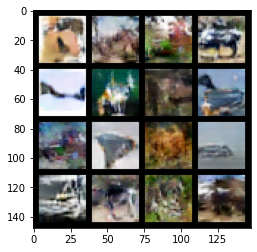

In [92]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

G.eval()

# This fu3tion takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(model):

    with torch.no_grad():
    
        noise = torch.randn(100, latent_dim, 1, 1)
        noise = noise.to(device)
        images = G(noise)
        images = images.cpu()
        images = to_img(images)
        
        np_imagegrid = torchvision.utils.make_grid(images[0:16], 4, 4).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

# plt.show()
visualise_output(G)

